In [ ]:
import pandas as pd
import igraph as ig
from ease import EASE
import seaborn as sns
import numpy as np
import xmltodict

In [40]:
tt = pd.read_xml(StringIO('./files/orphanet_gene_sets.xml'), encoding='ISO-8859-1')

XMLSyntaxError: Start tag expected, '<' not found, line 1, column 1 (<string>, line 1)

In [ ]:
# load kegg pathways

# load diasease gene sets
# load ORPHANET
with open('./files/orphanet_gene_sets.xml', 'rb') as orphanet_f:
    orphanet_dict = xmltodict.parse(orphanet_f)



In [ ]:
kegg_pathways = pd.read_csv(filepath_or_buffer='./files/kegg_hsa_pathways', names=['pathway', 'kegg_id'], sep='\t') # 36381
uniprot_ids = pd.read_csv(filepath_or_buffer='./files/uniprot_ids', names=['kegg_id', 'uniprot_id'], sep='\t', skiprows=1) # 517 not matched!!!  8251 matched
uniprot_ids = uniprot_ids[~(uniprot_ids['kegg_id'] == uniprot_ids['uniprot_id'])]
uniprot_ids.shape
id_map = uniprot_ids.set_index('kegg_id')['uniprot_id'].to_dict()
len(id_map)
kegg_pathways = kegg_pathways.replace(to_replace=id_map, limit=0)
kegg_pathways.columns = ['pathway', 'uniprot_id']
pathways_dict = kegg_pathways.groupby('pathway')['uniprot_id'].apply(list).to_dict()
# kegg_pathways = 
# # !!!!! SHOULD I FILTER OUT NON UNIPROT ONE?? !!! - probably yes
# KEGG ids point towards multiple uniprot accessions - how to handle multiple accessions
# have to filter out non matched !!!!!!

# number of kegg entries mapped to more than 1 uniprot entry
uniprot_ids_counts = uniprot_ids['kegg_id'].value_counts()
multi_mapped = uniprot_ids_counts.where(uniprot_ids_counts > 1).dropna().shape # 23 entries assigned more than 1 uniprot entry
print(f"number of kegg entries mapped to multiple uniprot entries: {multi_mapped}")


# number of kegg pathwways
print(f"Number of kegg pathways: {len(kegg_pathways['pathway'].unique())}")

/tmp/ipykernel_1944/321458049.py:7: FutureWarning: The 'limit' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  kegg_pathways = kegg_pathways.replace(to_replace=id_map, limit=0)


In [8]:
# get network data from pickle  
regulome_network_edges = pd.read_pickle(filepath_or_buffer='./files/human_regulome_filtered.gz', compression='infer')

regulome_network_graph = ig.Graph.DataFrame(regulome_network_edges, directed=True, use_vids = False)
regulome_network_graph_undirected = ig.Graph.DataFrame(regulome_network_edges, directed=False, use_vids = False)

In [207]:
# Investigate Leiden resolution
std_output = pd.DataFrame({
    'pathway_id': ['---'],
    'Overlap': [0],
    'Pvalue': [1],
    'FDR': [1],
    'FWER': [1] 
})
cov = 4000 # what should I set this to??

leiden_cluster_enrichment_dict = dict()
for res in np.arange(0, 10, 0.1):
    print(f"Reslution: {res}")
    clusters = regulome_network_graph_undirected.community_multilevel(weights='PPV',
                                                                          return_levels=False,
                                                                          resolution=res)
    
    # clusters = regulome_network_graph_undirected.community_leiden(objective_function='modularity',
    #                                                                 weights='PPV',
    #                                                                 resolution=res,
    #                                                                 beta=0.01,
    #                                                                 n_iterations=3) # only few small clusters and 1 large one

    enrichment_dict = dict()
    for (cluster_n, cluster) in enumerate(clusters.subgraphs()):
        
        query = cluster.vs['name']
        if len(query) > 1000:
            continue # how do I handle these? Filter out based on size?
        enrichment = EASE(query_set=query, genesets=pathways_dict, PT=cov)
        enrichment_dict[cluster_n] = (enrichment, len(query), query) # maybe save this as a namedtuple with enrihcment and subgraph
    leiden_cluster_enrichment_dict[res] = (enrichment_dict, len(clusters))

Reslution: 0.0
Reslution: 0.1
Reslution: 0.2
Reslution: 0.30000000000000004
Reslution: 0.4
Reslution: 0.5
Reslution: 0.6000000000000001
Reslution: 0.7000000000000001
Reslution: 0.8
Reslution: 0.9
Reslution: 1.0
Reslution: 1.1
Reslution: 1.2000000000000002
Reslution: 1.3
Reslution: 1.4000000000000001
Reslution: 1.5
Reslution: 1.6
Reslution: 1.7000000000000002
Reslution: 1.8
Reslution: 1.9000000000000001
Reslution: 2.0
Reslution: 2.1
Reslution: 2.2
Reslution: 2.3000000000000003
Reslution: 2.4000000000000004
Reslution: 2.5
Reslution: 2.6
Reslution: 2.7
Reslution: 2.8000000000000003
Reslution: 2.9000000000000004
Reslution: 3.0
Reslution: 3.1
Reslution: 3.2
Reslution: 3.3000000000000003
Reslution: 3.4000000000000004
Reslution: 3.5
Reslution: 3.6
Reslution: 3.7
Reslution: 3.8000000000000003
Reslution: 3.9000000000000004
Reslution: 4.0
Reslution: 4.1000000000000005
Reslution: 4.2
Reslution: 4.3
Reslution: 4.4
Reslution: 4.5
Reslution: 4.6000000000000005
Reslution: 4.7
Reslution: 4.80000000000

In [208]:
leiden_cluster_hits = dict()

threshold = 0.05
for (res, cluster_enrichments) in leiden_cluster_enrichment_dict.items():
    lowest_FDR_list = list()
    cluster_enrichments = cluster_enrichments[0]
    for _, enrichment in cluster_enrichments.items():
        enrichment = enrichment[0]
        # lowest_FDR = enrichment[enrichment.FDR == enrichment.FDR.idxmin()]
        lowest_FDR = enrichment[enrichment.FDR < threshold]
        if len(lowest_FDR) != 0:
            lowest_FDR_list.append(lowest_FDR)
    
    if len(lowest_FDR_list) == 0:
        leiden_cluster_hits[res] = pd.DataFrame({'pathway_id': [],
                                                'Overlap': [],
                                                'Pvalue': [],
                                                'FDR': [],
                                                'FWER': []})
        continue
    leiden_cluster_hits[res] = pd.concat(lowest_FDR_list)

(0.0, 10.0)

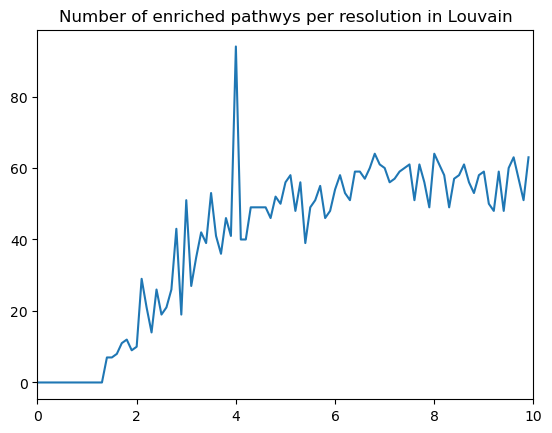

In [209]:

resolutions = leiden_cluster_hits.keys()
num_pathways = list()
for res, hits in leiden_cluster_hits.items():
    num_pathways.append(len(hits.pathway_id.unique()))
num_pathways
 
plot = sns.lineplot(x=resolutions, y=num_pathways)
plot.set_title("Number of enriched pathwys per resolution in Louvain")
plot.set_xlim([0,10])


<Axes: >

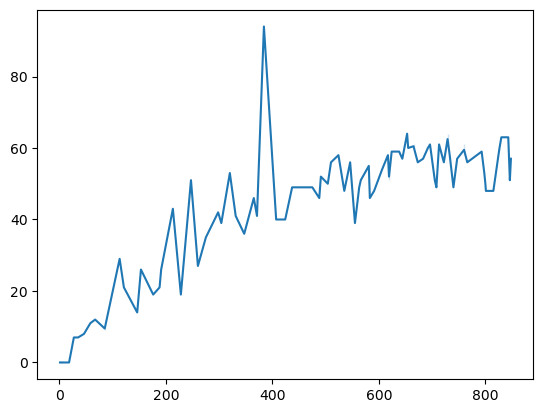

In [210]:
n_clusters = [n[1] for n in leiden_cluster_enrichment_dict.values()]

sns.lineplot(x=n_clusters, y=num_pathways)

<Axes: >

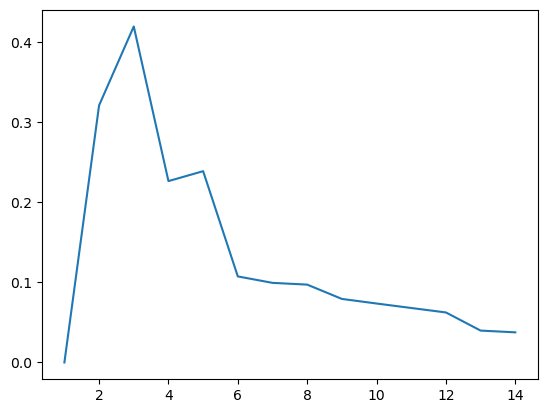

In [ ]:
css = [p/c for (p,c) in zip(num_pathways, n_clusters)]
sns.lineplot(x=resolutions, y = css) # looking at total number of clusters, not significant clusters
# maybe filter out clusters - above/below threshold

In [208]:
len(set(kegg_pathways['uniprot_id']).intersection(set(louvain_clusters.subgraphs()[500].vs['name'])))


1

In [210]:
ease_try[ease_try['Pvalue'] < 0.01]

,pathway_id,Overlap,Pvalue,FDR,FWER
194,path:hsa04630,7,0.005167,1.0,1.0


In [ ]:
infomap_clusters = regulome_network_graph.community_infomap(edge_weights='5:PPV', trials=10) # generaetd some small clusters and 1 large one

In [ ]:


leiden_clusters = regulome_network_graph_undirected.community_leiden(objective_function='modularity',
                                                          weights='5:PPV',
                                                          resolution=12.0,
                                                          beta=0.01,
                                                          n_iterations=3) # only few small clusters and 1 large one

In [123]:
# non-overlapping   

louvain_clusters = regulome_network_graph_undirected.community_multilevel(weights='PPV',
                                                                          return_levels=False,
                                                                          resolution=5)

In [167]:
cluster_5 = louvain_clusters.subgraphs()[200]
cluster_5.vs['name']

['P41235',
 'O43704',
 'Q9Y2Q3',
 'Q15155',
 'P32321',
 'A7E2Y1',
 'Q9Y623',
 'Q53S58',
 'Q9NVF9',
 'Q9BXJ7',
 'O00338',
 'Q16540',
 'P51570',
 'O60256',
 'P50225',
 'Q92561',
 'P13716',
 'P10635',
 'Q9H222',
 'O95255',
 'Q9H221',
 'P10153']